# Spectral Super Resolution with Cross-Modal Diffusion Models

This notebook demonstrates a simplified version of a model inspired by [this paper](https://arxiv.org/abs/2310.03024). We generate synthetic galaxy images and spectra, train encoders with a contrastive loss, and add a diffusion-based decoder to generate spectra conditioned on the image latent representation.


## 1. Synthetic Data Generation

In this section, we generate synthetic galaxy images and spectra.

In [101]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import random

def generate_synthetic_galaxy_image():
    """
    Generates a synthetic 64x64 grayscale image with a single Gaussian blob,
    mimicking a galaxy.
    """
    image = np.zeros((64, 64), dtype=np.float32)
    x_center = np.random.randint(20, 44)
    y_center = np.random.randint(20, 44)
    xv, yv = np.meshgrid(np.arange(64), np.arange(64))
    sigma = np.random.uniform(3, 8)
    blob = np.exp(-((xv - x_center)**2 + (yv - y_center)**2) / (2 * sigma**2))
    image += blob
    image = image / image.max()
    return image

def generate_synthetic_spectrum():
    """
    Generates a synthetic 1D spectrum over wavelengths 400-800 nm with a few Gaussian peaks
    (e.g., H-alpha near 656 nm) plus noise.
    """
    wavelengths = np.linspace(400, 800, 1000)  # in nm
    spectrum = np.zeros_like(wavelengths)
    peaks = [486, 500, 656] # H-beta, OIII, H-alpha
    for peak in peaks:
        amplitude = np.random.uniform(0.5, 1.0)
        sigma = np.random.uniform(5, 15)
        spectrum += amplitude * np.exp(-0.5 * ((wavelengths - peak) / sigma)**2)
    noise = np.random.normal(0, 0.05, size=wavelengths.shape)
    spectrum += noise
    spectrum = (spectrum - spectrum.min()) / (spectrum.max() - spectrum.min())
    return wavelengths, spectrum


## 2. Dataset Definition

We create a custom PyTorch Dataset that generates pairs of synthetic galaxy images and spectra on the fly.

In [102]:
class GalaxyDataset(Dataset):
    def __init__(self, num_samples=200):
        self.num_samples = num_samples

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        image = generate_synthetic_galaxy_image()  # (64,64)
        _, spectrum = generate_synthetic_spectrum()  # (1000,)
        image = np.expand_dims(image, axis=0)  # Add channel dimension
        image = torch.tensor(image, dtype=torch.float32)
        spectrum = torch.tensor(spectrum, dtype=torch.float32)
        return image, spectrum


## 3. Model Definitions

We define our image and spectrum encoders. These are simple architectures that compress the input data into a shared latent space.

In [103]:
class ImageEncoder(nn.Module):
    def __init__(self, embedding_dim=128):
        super(ImageEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),  # 32x32 # Ar: need to play with the detials here
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),  # 16x16
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),  # 8x8
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(64 * 8 * 8, embedding_dim)
        )
    
    def forward(self, x):
        return self.encoder(x)

class SpectrumEncoder(nn.Module):
    def __init__(self, embedding_dim=128):
        super(SpectrumEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(1000, 512),
            nn.ReLU(),
            nn.Linear(512, embedding_dim)
        )
    
    def forward(self, x):
        return self.encoder(x)


## 4. Dummy Diffusion Process and Contrastive Loss

We simulate a forward diffusion process by adding Gaussian noise and define a contrastive loss
that aligns the image and spectrum latent spaces.

In [104]:
def apply_diffusion(x, t):
    """
    A dummy diffusion function that adds Gaussian noise to simulate a diffusion step.
    The noise level is proportional to the time step 't'.
    """
    noise = torch.randn_like(x) * (t / 10.0)
    return x + noise

def contrastive_loss(image_embeddings, spectrum_embeddings, temperature=0.1):
    """
    Computes an InfoNCE loss that aligns image and spectrum embeddings.
    """
    batch_size = image_embeddings.shape[0]
    image_norm = image_embeddings / image_embeddings.norm(dim=1, keepdim=True)
    spectrum_norm = spectrum_embeddings / spectrum_embeddings.norm(dim=1, keepdim=True)
    logits = torch.mm(image_norm, spectrum_norm.t()) / temperature
    labels = torch.arange(batch_size).to(logits.device)
    loss_i = nn.CrossEntropyLoss()(logits, labels)
    loss_s = nn.CrossEntropyLoss()(logits.t(), labels) #Ar: need to understand the math here
    loss = (loss_i + loss_s) / 2
    return loss


## 5. Training Setup

We set hyperparameters, create the dataset and dataloader, and instantiate our encoders and optimizer.

In [105]:
embedding_dim = 128
batch_size = 16
num_epochs = 5
learning_rate = 1e-3

dataset = GalaxyDataset(num_samples=200)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
image_encoder = ImageEncoder(embedding_dim=embedding_dim).to(device)
spectrum_encoder = SpectrumEncoder(embedding_dim=embedding_dim).to(device)

optimizer = optim.Adam(list(image_encoder.parameters()) + list(spectrum_encoder.parameters()), lr=learning_rate)


## 6. Training Loop

We train the model by adding noise to the inputs (simulating diffusion), encoding them, and
optimizing a contrastive loss between the modalities.

In [106]:
print("Starting training...")
for epoch in range(num_epochs):
    total_loss = 0
    for image, spectrum in dataloader:
        image = image.to(device)
        spectrum = spectrum.to(device)
        t = random.uniform(0, 1)
        image_noisy = apply_diffusion(image, t)
        spectrum_noisy = apply_diffusion(spectrum, t)
        
        img_emb = image_encoder(image_noisy)
        spec_emb = spectrum_encoder(spectrum_noisy)
        
        loss = contrastive_loss(img_emb, spec_emb)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    avg_loss = total_loss / len(dataloader)
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {avg_loss:.4f}")

print("Training complete!")


Starting training...
Epoch 1/5, Loss: 2.7331
Epoch 2/5, Loss: 2.7195
Epoch 3/5, Loss: 2.7193
Epoch 4/5, Loss: 2.7193
Epoch 5/5, Loss: 2.7193
Training complete!


## 7. Visualization of Synthetic Data

We visualize one example of a synthetic galaxy image and its corresponding spectrum.

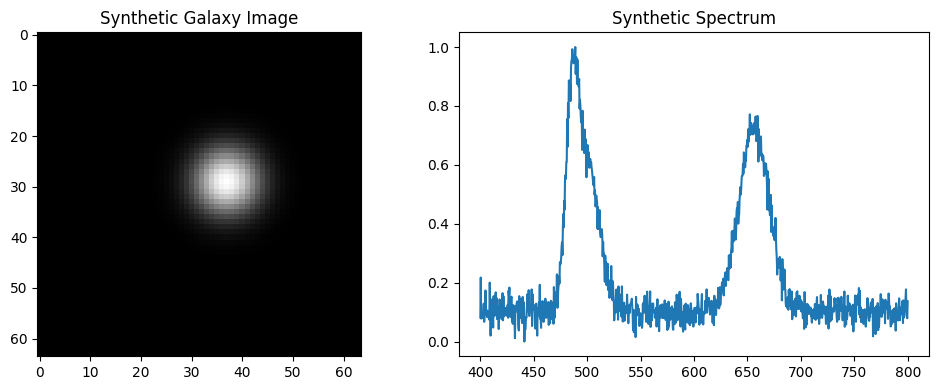

In [107]:
image, spectrum = dataset[0]
wavelengths = np.linspace(400, 800, 1000)

fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].imshow(image.squeeze(), cmap="gray")
ax[0].set_title("Synthetic Galaxy Image")
ax[1].plot(wavelengths, spectrum.numpy())
ax[1].set_title("Synthetic Spectrum")
plt.tight_layout()
plt.show()


## 8. Diffusion Decoder for Spectrum Generation

We add a conditional diffusion-based spectrum generator. This module denoises a noisy spectrum,
conditioned on the image latent vector. We then define a reverse diffusion process to generate
a spectrum starting from random noise.

In [108]:
class SpectrumDiffusionDecoder(nn.Module): # start reading from here
    def __init__(self, embedding_dim=128, spectrum_dim=1000):
        super(SpectrumDiffusionDecoder, self).__init__()
        # A simple MLP that conditions on both the noisy spectrum and the image latent
        self.net = nn.Sequential(
            nn.Linear(spectrum_dim + embedding_dim, 512),
            nn.ReLU(),
            nn.Linear(512, spectrum_dim)
        )
    
    def forward(self, noisy_spectrum, image_latent):
        # Expand image latent to match batch size if needed and concatenate with the noisy spectrum.
        cond = image_latent.expand(noisy_spectrum.size(0), -1)
        x = torch.cat([noisy_spectrum, cond], dim=1)
        return self.net(x)

def reverse_diffusion(image_latent, diffusion_decoder, steps=10, spectrum_dim=1000):
    """
    A dummy reverse diffusion process.
    Starting from pure noise, iteratively refine the spectrum using the diffusion decoder,
    conditioned on the image latent.
    """
    # Start with an initial random noise spectrum.
    x = torch.randn(1, spectrum_dim).to(image_latent.device)
    step_size = 1.0 / steps
    for step in reversed(range(1, steps + 1)):
        # In a real diffusion model, the network predicts the noise; here we simulate by a direct update.
        noise_estimate = diffusion_decoder(x, image_latent)
        # Update: subtract a fraction of the predicted noise to denoise.
        x = x - step_size * noise_estimate
    return x

def generate_spectrum_via_diffusion(image, image_encoder, diffusion_decoder, steps=10):
    """
    Generates a spectrum for a given galaxy image using a reverse diffusion process.
    The image is encoded to obtain its latent representation, which then conditions the diffusion decoder.
    """
    # Ensure the image has shape (batch_size, channels, height, width)
    image_tensor = torch.tensor(image, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)
    with torch.no_grad():
        # Obtain the latent representation of the input image
        image_latent = image_encoder(image_tensor)
        # Run the reverse diffusion process to generate a spectrum
        generated_spectrum = reverse_diffusion(image_latent, diffusion_decoder, steps=steps)
    return generated_spectrum

# Instantiate the diffusion decoder (note: it is not trained in this dummy demo)
spectrum_diffusion_decoder = SpectrumDiffusionDecoder(embedding_dim=embedding_dim, spectrum_dim=1000).to(device)


## 9. Generate and Visualize Spectrum from Dummy Galaxy

We generate a new dummy galaxy image, then use our diffusion decoder to generate a spectrum
conditioned on the image latent representation.

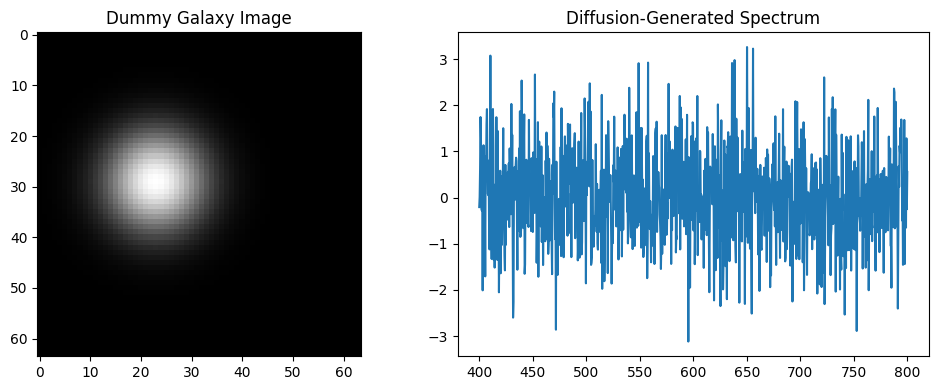

In [109]:
# Generate a new dummy galaxy image
dummy_image = generate_synthetic_galaxy_image()

# Use the diffusion decoder to generate a spectrum conditioned on the image latent
generated_spec = generate_spectrum_via_diffusion(dummy_image, image_encoder, spectrum_diffusion_decoder, steps=10)

# Visualization of the dummy galaxy and its generated spectrum via diffusion
wavelengths = np.linspace(400, 800, 1000)
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].imshow(dummy_image, cmap="gray")
ax[0].set_title("Dummy Galaxy Image")
ax[1].plot(wavelengths, generated_spec.cpu().numpy().squeeze())
ax[1].set_title("Diffusion-Generated Spectrum")
plt.tight_layout()
plt.show()
